# VAE Training

## imports

In [6]:
import os
import numpy as np

from utils.loaders import load_mnist

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## data

In [7]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## Pytorch VAE

In [8]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

class PytorchAutoencoder(nn.Module):
    def __init__(
        self,
        img_size,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        encoder_conv_padding,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        decoder_conv_t_padding,
        z_dim,
        use_batch_norm = False,
        use_dropout = False,
    ):
        super().__init__()
        self.img_size = img_size
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.encoder_conv_padding = encoder_conv_padding
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.decoder_conv_t_padding = decoder_conv_t_padding
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)
        
        self._decoder_size = None

        self._build_encoder()
        self._build_decoder()
        self._initialize_weights()

    def _build_encoder(self):
        ### THE ENCODER
        self.encoder = nn.Sequential()
        in_channels = self.img_size[0]
        sample = torch.zeros(*self.img_size).unsqueeze(0)
        for i in range(self.n_layers_encoder):
            out_channels = self.encoder_conv_filters[i]
            kernel = self.encoder_conv_kernel_size[i]
            strides = self.encoder_conv_strides[i]
            padding = self.encoder_conv_padding[i]
            conv_layer = nn.Conv2d(
                in_channels,
                out_channels,
                kernel,
                strides,
                padding,
            )
            self.encoder.add_module("encoder_conv_" + str(i), conv_layer)
            
            if self.use_batch_norm:
                bn = nn.BatchNorm2d(self.encoder_conv_filters[i])
                self.encoder.add_module("ebn_" + str(i), bn)
                
            self.encoder.add_module("elrelu_" + str(i), nn.LeakyReLU(0.3))
        
            if self.use_dropout:
                dl = nn.Dropout2d(0.25)
                self.encoder.add_module("edrop2d_" + str(i), dl)
                
            in_channels = self.encoder_conv_filters[i]
            sample = conv_layer(sample)
        
        # get dimensions
        self._decoder_size = sample.shape[1:]
        nd = np.prod(self._decoder_size)
        
        self.encoder.add_module("eflatten", nn.Flatten())
        self.encoder.add_module("encoder_dist", nn.Linear(nd, 2 * self.z_dim))
        self.encoder.add_module("encoder_output", View((2, self.z_dim)))

    def _build_decoder(self):
        ### THE DECODER
        nd = np.prod(self._decoder_size)
        self.decoder = nn.Sequential()
        self.decoder.add_module("decoder_expand", nn.Linear(self.z_dim, nd))
        self.decoder.add_module("decoder_reshape", View(self._decoder_size))
        in_channels = self._decoder_size[0]
        for i in range(self.n_layers_decoder):
            out_channels = self.decoder_conv_t_filters[i]
            kernel = self.decoder_conv_t_kernel_size[i]
            strides = self.decoder_conv_t_strides[i]
            padding = self.decoder_conv_t_padding[i]
            conv_t_layer = nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel,
                strides,
                padding,
            )
            self.decoder.add_module("decoder_conv_t_" + str(i), conv_t_layer)
        
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    self.decoder.add_module("decoder_bn_" + str(i), nn.BatchNorm2d(out_channels))
                    
                self.decoder.add_module("decoder_lr_" + str(i), nn.LeakyReLU(0.3))
            else:
                self.decoder.add_module("decoder_lr_" + str(i), nn.LeakyReLU(0.3))
            in_channels = out_channels
            
    def forward(self, x):
        out = self.encoder(x)
        mu = out[:, 0]
        out = self.decoder(mu)
        return out
        
    def encode(self, x, sample=False):
        out = self.encoder(x)
        mu = out[:, 0]
        log_var = out[:, 1]
        if sample:
            sigma = torch.exp(log_var / 2.0)
            z = torch.normal(torch.zeros(mu.shape), torch.ones(sigma.shape)).to(device=str(x.device))
            out = mu + z * sigma
        else:
            out = torch.clone(mu)
        return out, mu, log_var
    
    def decode(self, x):
        out = self.decoder(x)
        return out
    
    def _vae_normal_kl_loss(self, mu, log_var):
        kl_loss = -0.5 * torch.sum(1.0 + log_var - mu ** 2 - torch.exp(log_var), axis=1)
        return torch.mean(kl_loss)
    
    def _vae_ls_loss(self, out, obs):
        ls_loss = torch.mean((out - obs) ** 2, axis=[1, 2, 3])
        return torch.mean(ls_loss)
    
    def _initialize_weights(self):
        with torch.no_grad():
            self.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if type(layer) in [nn.BatchNorm1d, nn.BatchNorm2d]:
            layer.weight.data.fill_(1.0)
            layer.bias.data.fill_(0.0)
        else:
            if hasattr(layer, "weight"):
                torch.nn.init.xavier_uniform_(layer.weight)

            if hasattr(layer, "bias"):
                layer.bias.data.fill_(0.0)
                
    def fit(self, X, learning_rate=0.0005, vae_alpha=0.5, batch_size=32, epochs=10, shuffle=True):
        optimizer = torch.optim.Adam(lr=learning_rate, params=self.parameters())
        dataset = TensorDataset(X)
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
        )

        loss_fn_ls = nn.MSELoss(reduction="mean")
        for epoch in range(1, epochs + 1):
            n, total_loss = 0, 0.0
            for obs, in train_loader:
                out, mu, log_var = self.encode(obs, sample=True)
                kl_loss = self._vae_normal_kl_loss(mu, log_var)
                out = self.decode(out)
                ls_loss = self._vae_ls_loss(out, obs)
                # ls_loss = loss_fn_ls(out, obs)
                loss = vae_alpha * kl_loss + (1.0 - vae_alpha) * ls_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                n += out.shape[0]
                total_loss += float(loss.detach().item()) * obs.shape[0]
                
            avg_loss = 1.0 * total_loss / n
            print(f"Epoch {epoch} Loss: {vae_alpha * kl_loss:.6f}, {(1.0 - vae_alpha) * ls_loss:.6f}, {avg_loss:.6f}")
            print("    Memory Reserved: {:d}".format(torch.cuda.memory_reserved()))
            print("    Memory Allocated: {:d}".format(torch.cuda.memory_allocated()))
            
        # clean up
        del kl_loss, ls_loss, loss, out, mu, log_var
        torch.cuda.empty_cache()
            
        return self

In [9]:
x_train_pt = (
    torch
    .from_numpy(x_train)
    .to(torch.float32)
    .movedim(3, 1)
)
x_train_pt = x_train_pt.to(device="cuda")
x_test_pt = (
    torch
    .from_numpy(x_test)
    .to(torch.float32)
    .movedim(3, 1)
)
x_test_pt = x_test_pt.to(device="cuda")

In [10]:
pytorch_model = PytorchAutoencoder(
    img_size=list(x_train_pt[0].shape),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 2, 2, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    encoder_conv_padding=[1, 0, 0, 1],
    decoder_conv_t_filters=[64, 64, 32, 1],
    decoder_conv_t_kernel_size=[3, 2, 2, 3],
    decoder_conv_t_strides=[1, 2, 2, 1],
    decoder_conv_t_padding=[1, 0, 0, 1],
    z_dim=2,
    use_batch_norm=True,
    use_dropout=False,
)
pytorch_model.to(device="cuda")

PytorchAutoencoder(
  (encoder): Sequential(
    (encoder_conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ebn_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_0): LeakyReLU(negative_slope=0.3)
    (encoder_conv_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (ebn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_1): LeakyReLU(negative_slope=0.3)
    (encoder_conv_2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (ebn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_2): LeakyReLU(negative_slope=0.3)
    (encoder_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ebn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_3): LeakyReLU(negative_slope=0.3)
    (eflatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_dist): Linear(in_f

In [11]:
torch.cuda.memory_allocated() / 2 ** 30

0.2062053680419922

In [12]:
# could try clustering metrics as a surrogate loss function...
# also could mess with learning rate scheduler...
pytorch_model.fit(
    x_train_pt,
    epochs=10,
    vae_alpha=0.0001,
    learning_rate=0.0005,
)

Epoch 1 Loss: 0.000816, 0.049203, 0.057810
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 2 Loss: 0.000695, 0.053771, 0.049644
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 3 Loss: 0.000723, 0.048428, 0.047504
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 4 Loss: 0.000755, 0.042789, 0.046323
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 5 Loss: 0.000754, 0.047819, 0.045529
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 6 Loss: 0.000921, 0.046932, 0.044889
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 7 Loss: 0.000787, 0.043400, 0.044447
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 8 Loss: 0.000976, 0.044848, 0.044089
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 9 Loss: 0.000847, 0.042781, 0.043733
    Memory Reserved: 270532608
    Memory Allocated: 223397376
Epoch 10 Loss: 0.000700, 0.042127, 0.043416
  

PytorchAutoencoder(
  (encoder): Sequential(
    (encoder_conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ebn_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_0): LeakyReLU(negative_slope=0.3)
    (encoder_conv_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (ebn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_1): LeakyReLU(negative_slope=0.3)
    (encoder_conv_2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (ebn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_2): LeakyReLU(negative_slope=0.3)
    (encoder_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ebn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_3): LeakyReLU(negative_slope=0.3)
    (eflatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_dist): Linear(in_f

In [13]:
torch.cuda.memory_allocated() / 2 ** 30

0.20675897598266602

In [14]:
torch.cuda.memory_reserved() / 2**30

0.2109375

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
pytorch_model.eval()
with torch.no_grad():
    pts, _, _ = pytorch_model.encode(x_test_pt)
    pts = pts.cpu().detach().numpy()

In [17]:
pts.shape

(10000, 2)

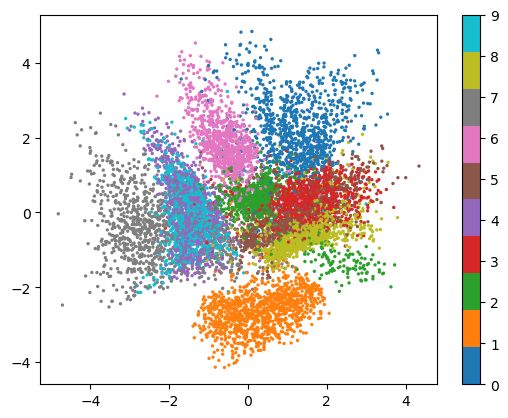

In [16]:
plt.scatter(pts[:, 0], pts[:, 1], s=2, c=y_test, cmap="tab10")
plt.colorbar()

In [31]:
# # scratch code to turn off grad for parameters of model
# # could be useful in futurue
# for p in pytorch_model.parameters():
#     p.requires_grad_(False)

In [18]:
torch.cuda.memory_allocated() / 2 ** 30

0.2069082260131836

In [19]:
torch.cuda.memory_reserved() / 2 ** 30

2.08203125

In [21]:
del _, pts
torch.cuda.empty_cache()

In [22]:
torch.cuda.memory_allocated() / 2 ** 30

0.20675897598266602

In [23]:
torch.cuda.memory_reserved() / 2 ** 30

0.2109375